### Import packages

In [2]:
import numpy as np 
import pandas as pd 
import seaborn as sn
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from matplotlib.gridspec import GridSpec as gs
from scipy.signal import savgol_filter

### Upload raw data files

In [3]:
path = '/Users/saz462/Desktop/ClpTAC/Experiments/Recombineering_growthcurves/'

plate1_od = pd.read_excel(path + "20230807_TPDrec_growthcurves.xlsx", sheet_name='OD600')
#replace the strings with times with numerical values
plate1_od['Time'] = plate1_od['Time'].str.replace('s', '').astype(int)
plate1_od['Time'] = plate1_od['Time']/60

plate2_od = pd.read_excel(path + "20230809_TPDrec_growthcurves.xlsx", sheet_name='OD600')
#replace the strings with times with numerical values
plate2_od['Time'] = plate2_od['Time'].str.replace('s', '').astype(int)
plate2_od['Time'] = plate2_od['Time']/60

plate3_od = pd.read_excel(path + "20240105_TPDrec_growthcurves.xlsx", sheet_name='OD600')
#replace the strings with times with numerical values
plate3_od['Time'] = plate3_od['Time'].str.replace('s', '').astype(int)
plate3_od['Time'] = plate3_od['Time']/60

plate4_od = pd.read_excel(path + "20240110_TPDrec_growthcurves.xlsx", sheet_name='OD600')
#replace the strings with times with numerical values
plate4_od['Time'] = plate4_od['Time'].str.replace('s', '').astype(int)
plate4_od['Time'] = plate4_od['Time']/60

plate5_od = pd.read_excel(path + "20240214_HW84_growthcurve.xlsx", sheet_name='OD600')
#replace the strings with times with numerical values
plate5_od['Time'] = plate5_od['Time'].str.replace('s', '').astype(int)
plate5_od['Time'] = plate5_od['Time']/60


#Select subset of time
plate1_od = plate1_od.iloc[:90]
plate2_od = plate2_od.iloc[:90]
plate3_od = plate3_od.iloc[:90]
plate4_od = plate4_od.iloc[:90]
plate5_od = plate5_od.iloc[:90]

### Create keys matching plate wells to strains and conditions

In [23]:
#For plates 1 and 2, 96 well plates were setup such that wells A1, B1, C1, D1 correspond to a given strain with A1/B1 corresponding to DMSO condition and C1/D1 corresponding to Rapa condition. 

#Generate lists of the wells grouped in order 
wells = []
rows = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
cols = [str(i) for i in range(1,13)]
for i in range(96):
    row_index = (i%4) + 4*(i//48)
    col_index = (i//4)%12
    well = rows[row_index]+cols[col_index]
    wells.append(well)


dataframe_columns = ['Strain', '-RAPA1', '-RAPA2', '+RAPA1', '+RAPA2', 'Plate']
dataframe_rows = ['NaN', 'NaN', 'Mmpl3_1', 'Mmpl3_2', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 
        'RbpA_1', 'RbpA_2', 'NaN', 'SecA1', 'NaN', 'NaN', 'NaN', 'NaN', 'Ffh', 'NaN', 'NaN', 'NaN']

#Create a dataframe with the wells that correspond to each strain
df1 = pd.DataFrame(columns=dataframe_columns)
for i in range(len(dataframe_rows)):
    df1.loc[i] = [None] * len(dataframe_columns)
    df1.loc[i, dataframe_columns] = dataframe_rows[i], wells[4*i+0], wells[4*i+1], wells[4*i+2], wells[4*i+3], '1'

dataframe_rows_2 = ['NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'PyrG_1', 'PyrG_2', 'RpoB_1', 'RpoB_2', 'NaN', 'NaN', 'NaN']
l = len(df1)
for i in range(len(dataframe_rows_2)):
    df1.loc[i+l] = [None] * len(dataframe_columns)
    df1.loc[i+l, dataframe_columns] = dataframe_rows_2[i], wells[4*i+0], wells[4*i+1], wells[4*i+2], wells[4*i+3], '2'

In [24]:
#Create strain key table for plate 3
d = {'Strain': ['NaN','NaN','NaN','NusG-1','NusG-2','RpsD-1','RpsD-3','LeuS-4','LeuS-6','MutT4-4'], 
 '-RAPA1': ['C2','C3','C4','C5','C6','C7','C8','C9','C10','C11'], 
 '-RAPA2': ['D2','D3','D4','D5','D6','D7','D8','D9','D10','D11'], 
 '+RAPA1': ['E2','E3','E4','E5','E6','E7','E8','E9','E10','E11'], 
 '+RAPA2': ['F2','F3','F4','F5','F6','F7','F8','F9','F10','F11'],
 'Plate': ['3','3','3','3','3','3','3','3','3','3',]}

df2 = pd.DataFrame(data=d)

In [25]:
#Create strain key table for plate 4
d = {'Strain': ['MutT4-4-2','MutT4-4-3','NaN','NaN','NusG-1-2','NusG-2-2','RpsD-1-2','RpsD-3-2','AtpA-1-1','AtpA-1-2'], 
 '-RAPA1': ['C2','C3','C4','C5','C6','C7','C8','C9','C10','C11'], 
 '-RAPA2': ['D2','D3','D4','D5','D6','D7','D8','D9','D10','D11'], 
 '+RAPA1': ['E2','E3','E4','E5','E6','E7','E8','E9','E10','E11'], 
 '+RAPA2': ['F2','F3','F4','F5','F6','F7','F8','F9','F10','F11'],
 'Plate': ['4','4','4','4','4','4','4','4','4','4',]}

df3 = pd.DataFrame(data=d)

In [26]:
#Create strain key table for plate 5
d = {'Strain': ['HW84_1_1','HW84_1_2','HW84_2_1','HW84_2_2','RbpA_3', 'HW84_1_3', 'HW84_2_3'], 
 '-RAPA1': ['C2','C3','C4','C5','C6','C7','C8'], 
 '-RAPA2': ['D2','D3','D4','D5','D6','D7','D8'], 
 '+RAPA1': ['E2','E3','E4','E5','E6','E7','E8'], 
 '+RAPA2': ['F2','F3','F4','F5','F6','F7','F8'],
 'Plate': ['5','5','5','5','5','5', '5']}

df4 = pd.DataFrame(data=d)

In [27]:
#Join all the key tables into one dataframe
df = pd.concat([df1, df2, df3, df4], ignore_index=True)
df = df[~df['Strain'].str.startswith('NaN')]

### Define plotting parameters

In [28]:
lw = 3
fs = 12

### Plot an individual graph

Text(0, 0.5, 'log2(OD600)')

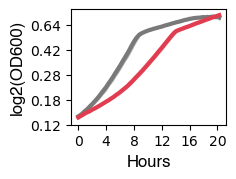

In [29]:
colors = [np.array([40,40,40])/255,np.array([225,60,80])/255,np.array([121,121,121])/255]

strain = 'RbpA_3'
strain_wells = df.loc[df['Strain'] == strain].values

#Use the Plate column to determine which dataframe to pull values from
if strain_wells[0][5] == '1':
    data = plate1_od.copy()
elif strain_wells[0][5] == '2':
    data = plate2_od.copy()
elif strain_wells[0][5] == '3':
    data = plate3_od.copy()
elif strain_wells[0][5] == '4':
    data = plate4_od.copy()
elif strain_wells[0][5] == '5':
    data = plate5_od.copy()
    
rapa_minus = data[[strain_wells[0][1],strain_wells[0][2]]].values
rapa_plus = data[[strain_wells[0][3],strain_wells[0][4]]].values
std_minus = rapa_minus.std(axis=1)
std_plus = rapa_plus.std(axis=1)
time = data['Time'].values

# find elbow point
rapa_minus_trunc_index = 8 #,max(0,np.where(rapa_minus.mean(axis=1)>0.15)[0][0]-int(200/15))


#create a figure canvas
fig=plt.figure(figsize=(2,1.5))
ax=fig.add_subplot()

trunc_log2_minus = np.log2(rapa_minus.mean(axis=1)[rapa_minus_trunc_index:])
trunc_log2_plus = np.log2(rapa_plus.mean(axis=1)[rapa_minus_trunc_index:])
trunc_std_minus = std_minus[rapa_minus_trunc_index:]
trunc_std_plus = std_plus[rapa_minus_trunc_index:]

trunc_x = np.arange(len(trunc_log2_minus))*15

# plot log2-transformed mean
ax.plot(trunc_x,trunc_log2_minus,color=colors[2],ls='-',lw=lw)
ax.plot(trunc_x,trunc_log2_plus,color=colors[1],ls='-',lw=lw)
ax.fill_between(trunc_x, 
                np.log2(rapa_minus.mean(axis=1)[rapa_minus_trunc_index:]-1*trunc_std_minus),
                np.log2(rapa_minus.mean(axis=1)[rapa_minus_trunc_index:]+1*trunc_std_minus),
                color=colors[2],alpha=0.5)

ax.fill_between(trunc_x, 
                np.log2(rapa_plus.mean(axis=1)[rapa_minus_trunc_index:]-1*trunc_std_plus),
                np.log2(rapa_plus.mean(axis=1)[rapa_minus_trunc_index:]+1*trunc_std_plus),
                color=colors[1],alpha=0.5)


#ax.fill_between(trunc_x, np.log2(rapa_plus[rapa_minus_trunc_index:,0]),np.log2(rapa_plus[rapa_minus_trunc_index:,1]),color=colors[1],alpha=0.5)


# customize X axis
ax.set_xticks(np.arange(0,int(time.max()/60),4)*60)
ax.set_xticklabels(np.arange(0,int(time.max()/60),4))
ax.set_xlabel('Hours',fontsize=12, fontname='Helvetica')

# customize Y axis
y_ticks_log2 = np.linspace(np.log2(0.64),np.log2(0.12),5)
ax.set_yticks(y_ticks_log2)
ax.set_yticklabels(np.round(2**y_ticks_log2,2))
ax.set_ylabel('log2(OD600)',fontsize=12, fontname='Helvetica')

#ax.set_title(strain,va='top',fontsize=12,fontname='Helvetica')

### Plot all graphs onto a single figure

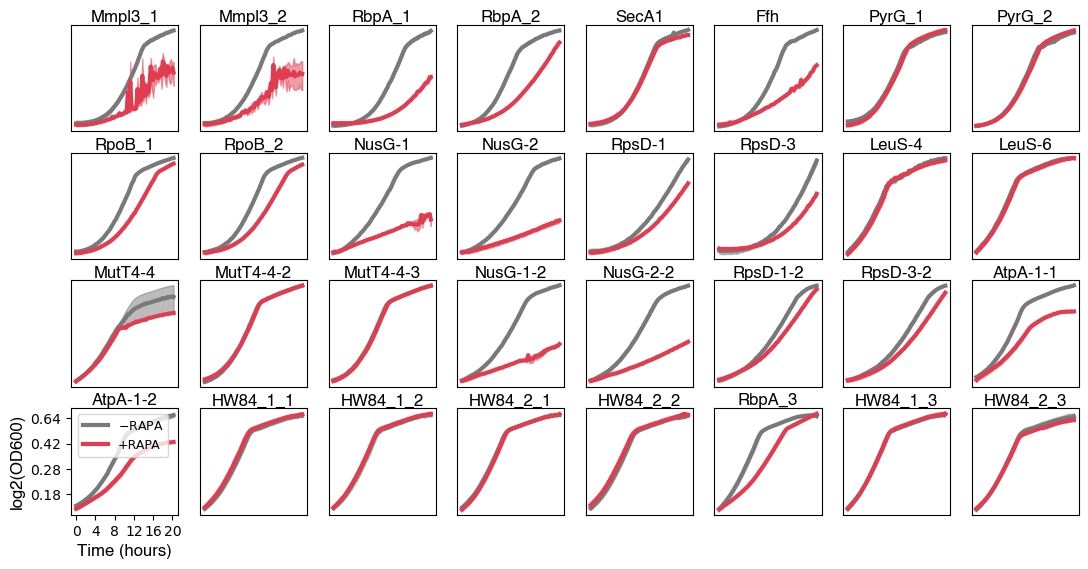

In [31]:
fig=plt.figure(figsize=(13,13))
grids= gs(8,8,hspace=0.2,wspace=0.2)
colors = [np.array([40,40,40])/255,np.array([225,60,80])/255,np.array([121,121,121])/255]


for i,k in enumerate(df['Strain']):
    strain = k
    strain_wells = df.loc[df['Strain'] == strain].values
    
    #Use the Plate column to determine which dataframe to pull values from
    if strain_wells[0][5] == '1':
        data = plate1_od.copy()
    elif strain_wells[0][5] == '2':
        data = plate2_od.copy()
    elif strain_wells[0][5] == '3':
        data = plate3_od.copy()
    elif strain_wells[0][5] == '4':
        data = plate4_od.copy()
    elif strain_wells[0][5] == '5':
        data = plate5_od.copy()
            
    time = data['Time'].values
    rapa_minus = data[[strain_wells[0][1],strain_wells[0][2]]].values
    rapa_plus = data[[strain_wells[0][3],strain_wells[0][4]]].values
    std_minus = rapa_minus.std(axis=1)
    std_plus = rapa_plus.std(axis=1)

    # find elbow point to determine starting point for data 
    rapa_minus_trunc_index = 8 #,max(0,np.where(rapa_minus.mean(axis=1)>0.15)[0][0]-int(200/15))

    trunc_log2_minus = np.log2(rapa_minus.mean(axis=1)[rapa_minus_trunc_index:])
    trunc_log2_plus = np.log2(rapa_plus.mean(axis=1)[rapa_minus_trunc_index:])
    trunc_std_minus = std_minus[rapa_minus_trunc_index:]
    trunc_std_plus = std_plus[rapa_minus_trunc_index:]

    trunc_x = np.arange(len(trunc_log2_minus))*15
    
    # determine row and column in grid
    r,c = i//8,i%8
    ax=fig.add_subplot(grids[r,c])
   
    # only label the bottom right panel 
    if r==3 and c==0:
        # customize X axis
        ax.set_xticks(np.arange(0,int(time.max()/60),4)*60)
        ax.set_xticklabels(np.arange(0,int(time.max()/60),4))
        ax.set_xlabel('Time (hours)',fontsize=fs, fontname='Helvetica')

        # customize Y axis
        y_ticks_log2 = np.linspace(np.log2(0.64),np.log2(0.12),5)
        ax.set_yticks(y_ticks_log2)
        ax.set_yticklabels(np.round(2**y_ticks_log2,2))
        ax.set_ylabel('log2(OD600)',fontsize=fs, fontname='Helvetica')
        
        # add legend
        ax.plot(trunc_x,trunc_log2_minus,color=colors[2],ls='-',lw=lw, label='$-$RAPA')
        ax.plot(trunc_x,trunc_log2_plus,color=colors[1],ls='-',lw=lw, label='+RAPA')
        ax.legend(loc="upper left", fontsize=fs-3)

                
    else:
        ax.set_xticks([])
        ax.set_yticks([])
        ax.plot(trunc_x,trunc_log2_minus,color=colors[2],ls='-',lw=lw)
        ax.plot(trunc_x,trunc_log2_plus,color=colors[1],ls='-',lw=lw)
        
    

    ax.set_title(strain,va='top',fontsize=fs,fontname='Helvetica')
    ax.fill_between(trunc_x, 
                    np.log2(rapa_minus.mean(axis=1)[rapa_minus_trunc_index:]-1*trunc_std_minus),
                    np.log2(rapa_minus.mean(axis=1)[rapa_minus_trunc_index:]+1*trunc_std_minus),
                    color=colors[2],alpha=0.5)

    ax.fill_between(trunc_x, 
                    np.log2(rapa_plus.mean(axis=1)[rapa_minus_trunc_index:]-1*trunc_std_plus),
                    np.log2(rapa_plus.mean(axis=1)[rapa_minus_trunc_index:]+1*trunc_std_plus),
                    color=colors[1],alpha=0.5)
    
#plt.savefig('/Users/saz462/Desktop/TPD_targets/Figures/TPDrec_growth_curves.svg',bbox_inches='tight', dpi = 600)

### Define which biological replicates to plot in the final figure

In [33]:
#Define a subset of substrates to plot and reorder the dataframe based on this list 
sub = ['NusG-2-2','RbpA_1','Ffh','Mmpl3_2','AtpA-1-2','RpoB_2','RpsD-3-2','MutT4-4-3','SecA1','HW84_1_3','PyrG_1','LeuS-4']
df_sub = df[df['Strain'].isin(sub)]
df_sub = pd.DataFrame({'Strain': sub}).merge(df_sub, on='Strain', how='left')

#Add a column of titles
titles = ['NusG','RbpA','Ffh','MmpL3','AtpA','RpoB','RpsD','MutT4','SecA1','No target','PyrG','LeuS']
df_sub['titles'] = titles

### Plot with smoothing

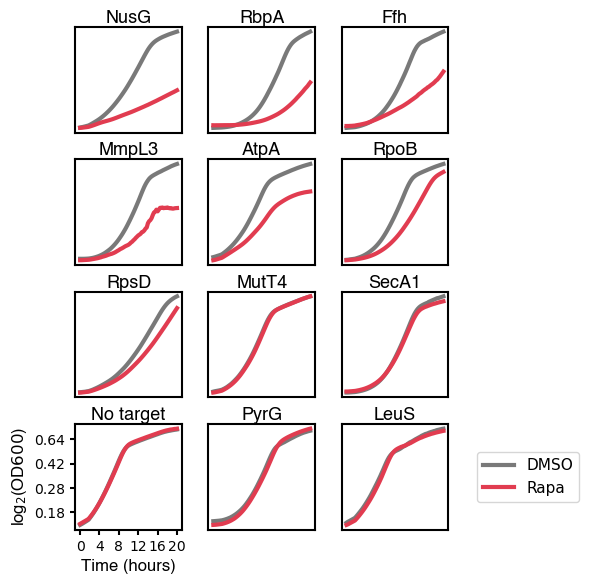

In [37]:
window_size = 8  # Adjust the window size as needed

fig=plt.figure(figsize=(8.25,8.25))
grids= gs(5,5,hspace=0.25,wspace=0.25)
colors = [np.array([40,40,40])/255,np.array([225,60,80])/255,np.array([121,121,121])/255]

for i,k in enumerate(df_sub['Strain']):
    strain = k
    strain_wells = df_sub.loc[df_sub['Strain'] == strain].values
    
    #Use the Plate column to determine which dataframe to pull values from
    if strain_wells[0][5] == '1':
        data = plate1_od.copy()
    elif strain_wells[0][5] == '2':
        data = plate2_od.copy()
    elif strain_wells[0][5] == '3':
        data = plate3_od.copy()
    elif strain_wells[0][5] == '4':
        data = plate4_od.copy()
    elif strain_wells[0][5] == '5':
        data = plate5_od.copy()
            
    time = data['Time'].values
    rapa_minus = data[[strain_wells[0][1],strain_wells[0][2]]].values
    rapa_plus = data[[strain_wells[0][3],strain_wells[0][4]]].values
    std_minus = rapa_minus.std(axis=1)
    std_plus = rapa_plus.std(axis=1)

    # find elbow point to determine starting point for data 
    rapa_minus_trunc_index = 9 #,max(0,np.where(rapa_minus.mean(axis=1)>0.15)[0][0]-int(200/15))

    trunc_log2_minus = np.log2(rapa_minus.mean(axis=1)[rapa_minus_trunc_index:])
    trunc_log2_plus = np.log2(rapa_plus.mean(axis=1)[rapa_minus_trunc_index:])
    trunc_std_minus = std_minus[rapa_minus_trunc_index:]
    trunc_std_plus = std_plus[rapa_minus_trunc_index:]

    trunc_x = np.arange(len(trunc_log2_minus))*15
    
    # determine row and column in grid
    r,c = i//3,i%3
    ax=fig.add_subplot(grids[r,c])
    
    #specify lw for ticks and spines
    tslw = 1.5
    
    #set the axis spine linewidth
    ax.spines[:].set_linewidth(tslw)
   
    # only label the bottom right panel 
    if r==3 and c==0:
        # customize X axis
        ax.set_xticks(np.arange(0,int(time.max()/60),4)*60)
        ax.set_xticklabels(np.arange(0,int(time.max()/60),4))
        ax.set_xlabel('Time (hours)',fontsize=fs, fontname='Helvetica')
        ax.tick_params(axis='x', which='both', width=tslw)

        # customize Y axis
        y_ticks_log2 = np.linspace(np.log2(0.64),np.log2(0.12),5)
        ax.set_yticks(y_ticks_log2)
        ax.set_yticklabels(np.round(2**y_ticks_log2,2))
        ax.set_ylabel('log$_2$(OD$600$)',fontsize=fs, fontname='Helvetica')
        ax.tick_params(axis='y', which='both', width=tslw)
            
                
    else:
        ax.set_xticks([])
        ax.set_yticks([])
        
    
    trunc_log2_minus_smooth = pd.Series(trunc_log2_minus).rolling(window=window_size, min_periods=1).mean().values
    trunc_log2_plus_smooth = pd.Series(trunc_log2_plus).rolling(window=window_size, min_periods=1).mean().values

        
    ax.plot(trunc_x,trunc_log2_minus_smooth,color=colors[2],ls='-',lw=lw)
    ax.plot(trunc_x,trunc_log2_plus_smooth,color=colors[1],ls='-',lw=lw)
    

    ax.set_title(strain_wells[0][6],va='top',fontsize=fs+1,fontname='Helvetica')
    
    '''
    ax.fill_between(trunc_x, 
                    np.log2(rapa_minus.mean(axis=1)[rapa_minus_trunc_index:]-1*trunc_std_minus),
                    np.log2(rapa_minus.mean(axis=1)[rapa_minus_trunc_index:]+1*trunc_std_minus),
                    color=colors[2],alpha=0.5)

    ax.fill_between(trunc_x, 
                    np.log2(rapa_plus.mean(axis=1)[rapa_minus_trunc_index:]-1*trunc_std_plus),
                    np.log2(rapa_plus.mean(axis=1)[rapa_minus_trunc_index:]+1*trunc_std_plus),
                    color=colors[1],alpha=0.5)
    '''
    
    #add legend to empty space 
    legend_ax=fig.add_subplot(grids[3,3])
    legend_ax.set_xticks([])
    legend_ax.set_yticks([])
    legend_ax.plot([],[],color=colors[2],ls='-',lw=lw, label='DMSO')
    legend_ax.plot([],[],color=colors[1],ls='-',lw=lw, label='Rapa')
    legend_ax.legend(loc="center", fontsize=fs-1)
    legend_ax.spines[:].set_visible(False)
    
#plt.savefig('/Users/saz462/Desktop/ClpTAC/Figures/Source_figures/HW84_Updates/5b_20240215_TPDrec_growth_curves.svg',bbox_inches='tight')
